## Plotting data with different units

### Imports, loading, functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
# Set random seed
SEED = 321
np.random.seed(SEED)

In [2]:
## Customization options
# plt.style.use(['fivethirtyeight'])#'seaborn-talk'])#,
plt.rcParams['figure.facecolor']='white'
plt.rcParams['figure.figsize']=(12,4)
# Import tick customization tools
import matplotlib.ticker as mticks
import matplotlib.dates as mdates
sns.set_context("talk", font_scale=0.9)

In [3]:
def format_xdates(ax, fig=None, xtick_fontweight='bold', title=None):
    """Formats x-axis with minor ticks every 3 months, and major ticks every year.
    Includes different grid options for visibility."""
    # Create the locator to place ticks every 3 months
    loc_3months = mdates.MonthLocator(interval=3)
    fmt_months = mdates.DateFormatter("%b")
    # For major year ticks
    loc_year = mdates.YearLocator()
    fmt_year = mdates.DateFormatter("%Y")
    
    # Change the font of the major ticks to stand out
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), fontweight=xtick_fontweight)
    
    # Customize major ticks
    ax.xaxis.set_major_locator(loc_year)
    ax.xaxis.set_major_formatter(fmt_year)
    # Customize minor ticks
    ax.xaxis.set_minor_locator(loc_3months)
    ax.xaxis.set_minor_formatter(fmt_months)

    # Making major-minor gridlines visually distinct
    ax.grid(which='major', axis='x', color='k')
    ax.grid(which='minor', axis='x', ls=':')
    if fig is None:
        fig = ax.get_figure()
    # Rotate dates
    fig.automft_xdate(which='major', rotation=90, ha='center')
    return fig, ax 
    

### Loading and preparing data

**Corona Virus Time Series - Cases**

In [4]:
df = pd.read_csv("Data/covid_us_county.csv")
display(df.head())
df.info()

,fips,county,state,lat,long,date,cases,state_code,deaths
0,1001.0,Autauga,Alabama,32.539527,-86.644082,2020-01-22,0,AL,0
1,1001.0,Autauga,Alabama,32.539527,-86.644082,2020-01-23,0,AL,0
2,1001.0,Autauga,Alabama,32.539527,-86.644082,2020-01-24,0,AL,0
3,1001.0,Autauga,Alabama,32.539527,-86.644082,2020-01-25,0,AL,0
4,1001.0,Autauga,Alabama,32.539527,-86.644082,2020-01-26,0,AL,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3017826 entries, 0 to 3017825
Data columns (total 9 columns):
 #   Column      Dtype  
---  ------      -----  
 0   fips        float64
 1   county      object 
 2   state       object 
 3   lat         float64
 4   long        float64
 5   date        object 
 6   cases       int64  
 7   state_code  object 
 8   deaths      int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 207.2+ MB


- This data is already long-form, so preprocessing will be faster.
- Do a state-wise analysis, combining values in all counties for each state.

In [5]:
df['state_code'].unique()

array(['AL', 'AK', nan, 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA',
       'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA',
       'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY',
       'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY'], dtype=object)

Examine the null value in the list of states

In [6]:
check = df[df['state_code'].isna()]
check

,fips,county,state,lat,long,date,cases,state_code,deaths
92106,60.0,NaN,American Samoa,-14.2710,-170.1320,2020-01-22,0,NaN,0
92107,60.0,NaN,American Samoa,-14.2710,-170.1320,2020-01-23,0,NaN,0
92108,60.0,NaN,American Samoa,-14.2710,-170.1320,2020-01-24,0,NaN,0
92109,60.0,NaN,American Samoa,-14.2710,-170.1320,2020-01-25,0,NaN,0
92110,60.0,NaN,American Samoa,-14.2710,-170.1320,2020-01-26,0,NaN,0
...,...,...,...,...,...,...,...,...,...
2718025,78.0,NaN,Virgin Islands,18.3358,-64.8963,2022-07-08,21103,NaN,119
2718026,78.0,NaN,Virgin Islands,18.3358,-64.8963,2022-07-09,21103,NaN,119
2718027,78.0,NaN,Virgin Islands,18.3358,-64.8963,2022-07-10,21103,NaN,119
2718028,78.0,NaN,Virgin Islands,18.3358,-64.8963,2022-07-11,21175,NaN,119


In [7]:
check['state'].unique()

array(['American Samoa', 'Diamond Princess', 'District of Columbia',
       'Grand Princess', 'Guam', 'Northern Mariana Islands',
       'Puerto Rico', 'Virgin Islands'], dtype=object)

- There were several cases in American Territories, along with some on cruise liners. Group these together under a single "cruise" classifier and add a code for the others

In [8]:
df.loc[ df['state']=='American Samoa', 'state_code'] = 'AS'
df.loc[ df['state']=='District of Columbia', 'state_code'] = "DC"
df.loc[ df['state']== 'Guam', 'state_code'] = "GU"
df.loc[ df['state']== 'Northern Mariana Islands ', 'state_code'] = "MP"
df.loc[ df['state']=='Puerto Rico', 'state_code'] = "PR"
df.loc[ df['state']=='Virgin Islands', 'state_code'] = "VI"
df.loc[ (df['state']=='Diamond Princess') | (df['state']=='Grand Princess'), 'state_code'] = "CR"
# Confirm additions to state column
df['state_code'].unique()

array(['AL', 'AK', 'AS', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'CR', 'DC',
       'FL', 'GA', 'GU', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA',
       'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH',
       'NJ', 'NM', 'NY', 'NC', 'ND', nan, 'OH', 'OK', 'OR', 'PA', 'PR',
       'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VI', 'VA', 'WA', 'WV',
       'WI', 'WY'], dtype=object)

**Prepare Datetime Index**

In [9]:
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df

,fips,county,state,lat,long,cases,state_code,deaths
date,,,,,,,,
2020-01-22,1001.0,Autauga,Alabama,32.539527,-86.644082,0,AL,0
2020-01-23,1001.0,Autauga,Alabama,32.539527,-86.644082,0,AL,0
2020-01-24,1001.0,Autauga,Alabama,32.539527,-86.644082,0,AL,0
2020-01-25,1001.0,Autauga,Alabama,32.539527,-86.644082,0,AL,0
2020-01-26,1001.0,Autauga,Alabama,32.539527,-86.644082,0,AL,0
...,...,...,...,...,...,...,...,...
2022-07-08,56045.0,Weston,Wyoming,43.839612,-104.567488,1667,WY,19
2022-07-09,56045.0,Weston,Wyoming,43.839612,-104.567488,1667,WY,19
2022-07-10,56045.0,Weston,Wyoming,43.839612,-104.567488,1667,WY,19


### Visualizing Time Series with Different Magnitudes

**Group data by state**

In [10]:
# Drop unneeded cols
df = df.drop(columns=['fips', 'lat', 'long'])

In [11]:
## Resample with daily freq and group county data together by state_code.
## Aggregate data with .sum() for total # cases per state per day
# Resample as daily freq
df_ts = df.groupby('state_code').resample("D").sum()
df_ts

C:\Users\Malue\AppData\Local\Temp\ipykernel_24920\3056714314.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_ts = df.groupby('state_code').resample("D").sum()


cases  deaths
state_code date                      
AK         2020-01-22       0       0
           2020-01-23       0       0
           2020-01-24       0       0
           2020-01-25       0       0
           2020-01-26       0       0
...                       ...     ...
WY         2022-07-08  165619    1834
           2022-07-09  165619    1834
           2022-07-10  165619    1834
           2022-07-11  165619    1834
           2022-07-12  167386    1845

[50568 rows x 2 columns]

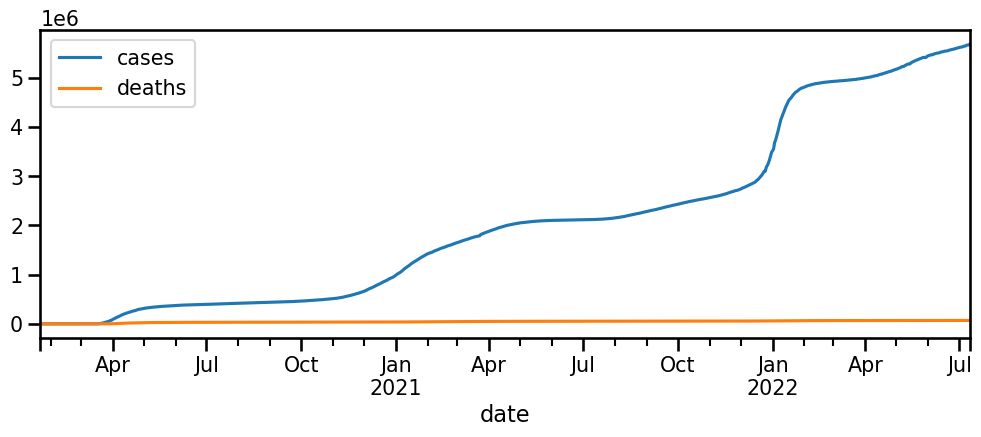

In [12]:
# Visualize one state, viewing both cases and deaths in the same figure
state_ts = df_ts.loc['NY'].copy()
ax = state_ts.plot();

- This figure makes it difficult to view the number of deaths because the line is so much smaller in terms of scale.
- A way to address this is to use two different axis measurements.

**Using twin axes**
- To use twin axes, start with making a fig and ax. The best way is using plt.subplots()
- After there is an ax, save a new ax from ax.twin()

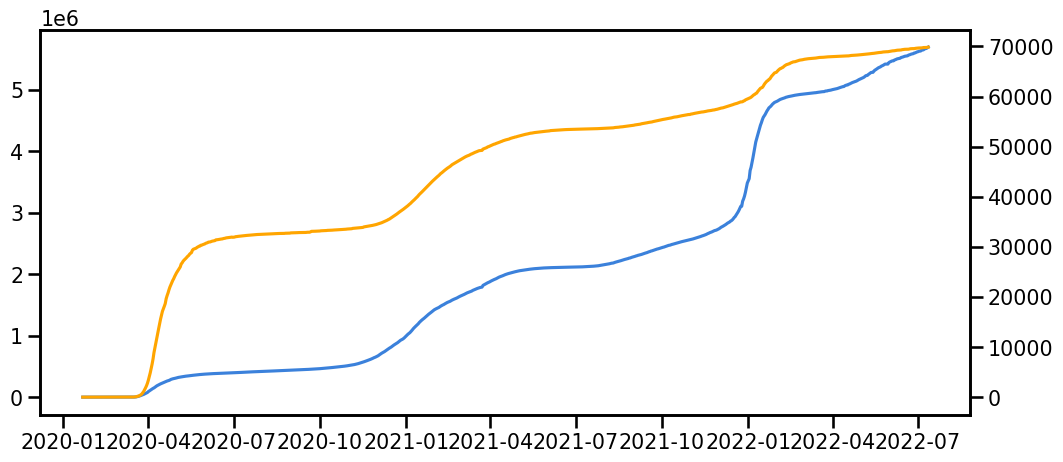

In [13]:
fig, ax1 = plt.subplots(figsize=(12,5))
## Plot first line on original ax
ax1.plot(state_ts.index, state_ts['cases'] ,color='#3b81db',label='Cases')
# Make twin axis and plot second line
ax2 = ax1.twinx()
ax2.plot(state_ts.index ,state_ts['deaths'],label='Deaths',color='orange')

In [14]:
# How many countries does our data cover?
#melted['Country/Region'].nunique()

- We can combine the use of .groupby and .resample("D") to get results group-wise
- By doing this, we will end with an index with two columns: a MultiIndex
    - When using .resample we must use an aggregate method, however, in this instance any agg method will return the same total so it doesn't matter which we pick. In the example here, we use .sum()

In [15]:
#df_ts = melted.groupby('Country/Region').resample("D").sum()
#df_ts

In [16]:
#df_ts.head().index

- However, we have now retained our ability to locate information by country.

In [17]:
#df_ts.loc['Afghanistan']

- Although trends in both lines are now visible, there is still room for improvement.

**Adding a legend to twin axis**
- Once there are two axes in one graph, legends become more difficult to use. The second legend to be called will obscure the first. There is a multi-step workaround to this problem
- To use a legend with twin axes:
    - Manually reconstruct a legend by giving ax1.legend() the lines, and labels for the lines
        - Get the lines themselves using: `lines=ax1.get_lines() + ax2.get_lines()`
        -  Get labels using: `labels = [l.get_label() for l in lines]`
    - Then use `ax1.legend(lines, labels)` to add the legend

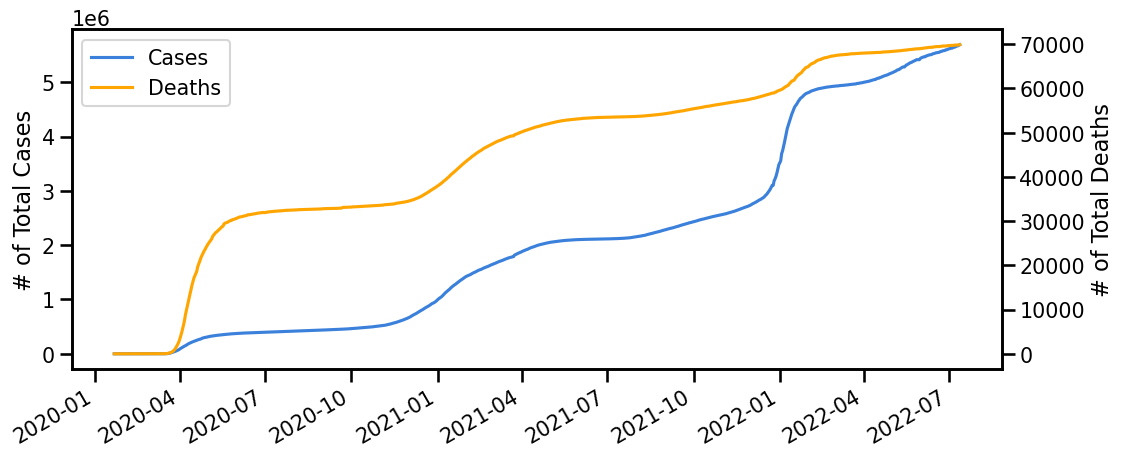

In [18]:
## Solution for having two legends
fig, ax1 = plt.subplots(figsize=(12,5))
ax1.plot(state_ts.index, state_ts['cases'], color='#3b81db', label='Cases')
ax1.set_ylabel("# of Total Cases")
# Make twin axis
ax2 = ax1.twinx()
ax2.plot(state_ts.index, state_ts['deaths'], label='Deaths', color='orange')
ax2.set_ylabel("# of Total Deaths")
# Removing the grids
ax1.grid(False)
ax2.grid(False)
# Making joined legend
lines = ax1.get_lines() + ax2.get_lines()
labels = [l.get_label() for l in lines]
ax2.legend(lines, labels, loc=0);
fig.autofmt_xdate()

- The legend is a necessity and looks satisfactory. Next is moving on to formatting the large tick values in a similar fashion as formatting date ticks.
- Before moving on to more customization, recap the previous work as a reusable function.

In [19]:
def plot_compare_cols(state_ts, col1='cases', color1='#3b81db',
                      col2='deaths', color2='orange',
                      ylabel1='# of Total Cases', ylabel2='# of Total Deaths',
                      figsize=(12,5)):
    # Solution for having two legends
    fig, ax1 = plt.subplots(figsize=figsize)
    ax1.plot(state_ts.index, state_ts[col1], color=color1, label=col1.title())
    ax1.set_ylabel(ylabel1)
    # Make twin axis
    ax2 = ax1.twinx()
    ax2.plot(state_ts.index, state_ts[col2], label=col2.title(), color=color2)
    ax2.set_ylabel(ylabel2)
    # Remove the grids
    ax1.grid(False)
    ax2.grid(False)
    # Making a joined legend
    lines = ax1.get_lines() + ax2.get_lines()
    labels = [l.get_label() for l in lines]
    ax2.legend(lines, labels, loc=0);
    fig.autofmt_xdate()
    return fig, (ax1, ax2)

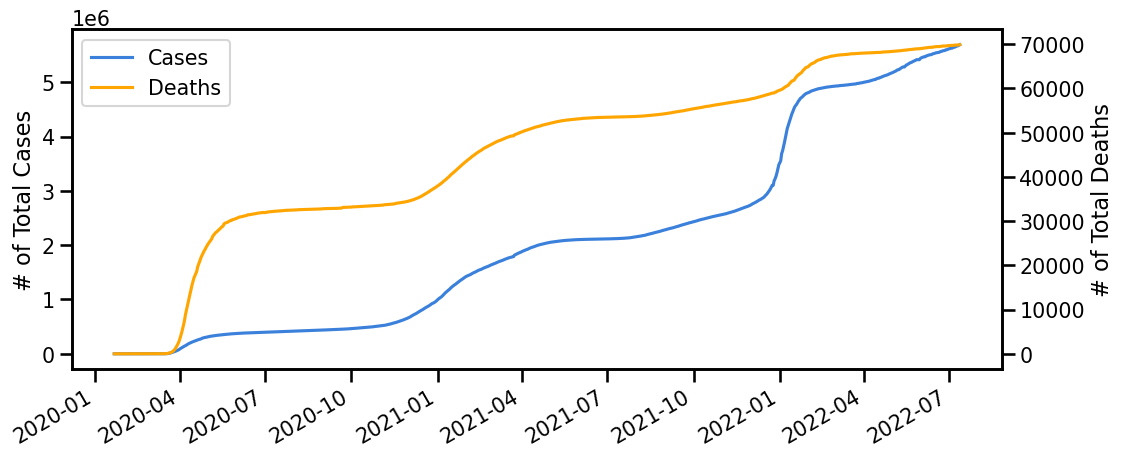

In [20]:
fig, (ax1, ax2) = plot_compare_cols(state_ts)

### Formatting non-date ticks using matplotlib.ticker

**Tick Formatting - Large #'s**

In [21]:
# The first of two options being covered is StrMethodFormatter, the other being FuncFormatter
import matplotlib.ticker as mticks

#### StrMethodFormatter

- Uses Python string format codes to change the tick label text
- Provide a string format that looks similar to an f-string; uses {} that contain a variable and : followed by a format code
- In this example, clean up y-axis ticks by:
    - Add a , separator for thousands
    - Show zero decimal places

In [22]:
str_fmt = mticks.StrMethodFormatter("{x:,.0f}")
str_fmt

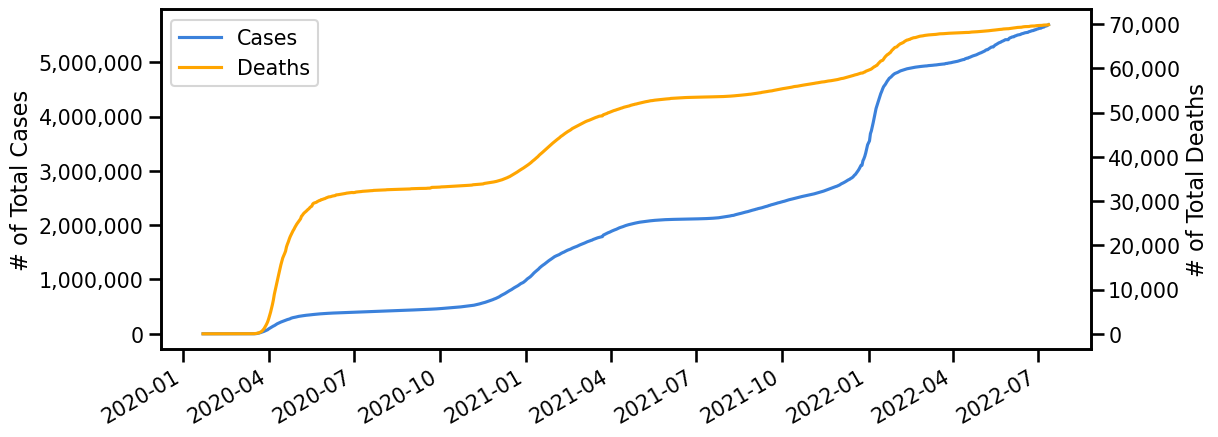

In [23]:
fig, (ax1, ax2) = plot_compare_cols(state_ts)
ax1.yaxis.set_major_formatter(str_fmt)
ax2.yaxis.set_major_formatter(str_fmt)

#### FuncFormatter

- The second option for tick formatting is more involved and requires the creation of a function that accepts `x` and `pos` values
- It then returns a string with the desired tick label for each x
- To use for FuncFormatter:
    - Create a function that accepts 2 arguments: x and pos
    - Calculate whatever modification to x is required
    - Use f-strings and format codes to specify how to change x

**Tip: Writing large numbers in Python**
- Python will accept numbers written as regular values: 1000000
- Scientific notation: 1e6
- With underscores: 1_000_000

In [24]:
# Custom functions for formatting
def millions(x, pos):
    """function for use with matplotlib FuncFormatter - formats money in millions"""
    new_x = x/1_000_000
    return f"{new_x:,.0f}M"
def thousands(x, pos):
    """function for use with matplotlib FuncFormatter - formats money in thousands"""
    new_x = x/1_000
    return f"{new_x:,.0f}K"
# Create the formatters
fmt_mill = mticks.FuncFormatter(millions)
fmt_thous = mticks.FuncFormatter(thousands)

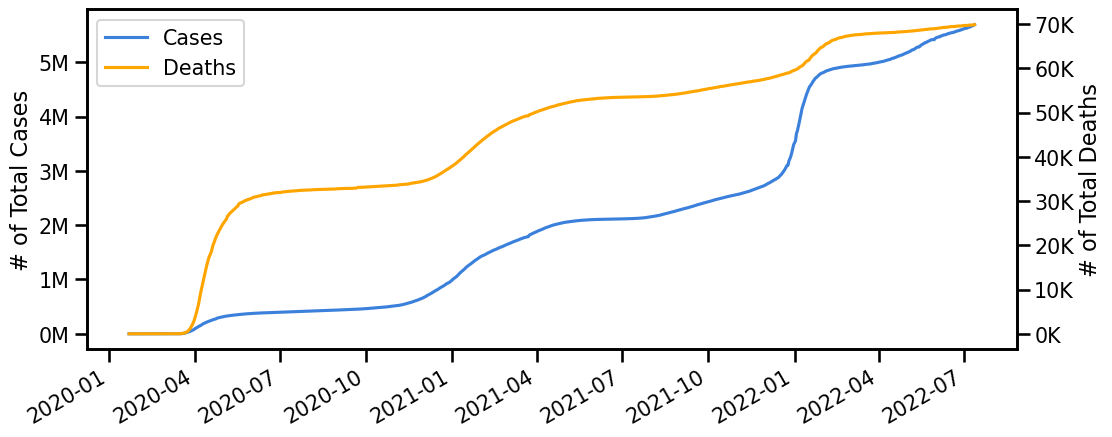

In [25]:
fig, (ax1, ax2) = plot_compare_cols(state_ts)
# Set the axis' major formatter
ax1.yaxis.set_major_formatter(fmt_mill)
ax2.yaxis.set_major_formatter(fmt_thous)

#### Combining tick formatting with date formatting

In [26]:
# Create locator to place ticks every 3 months
loc_3months = mdates.MonthLocator(interval=3)
fmt_months = mdates.DateFormatter("%b")
# Major year ticks
loc_year = mdates.YearLocator()
fmt_year = mdates.DateFormatter("%Y")

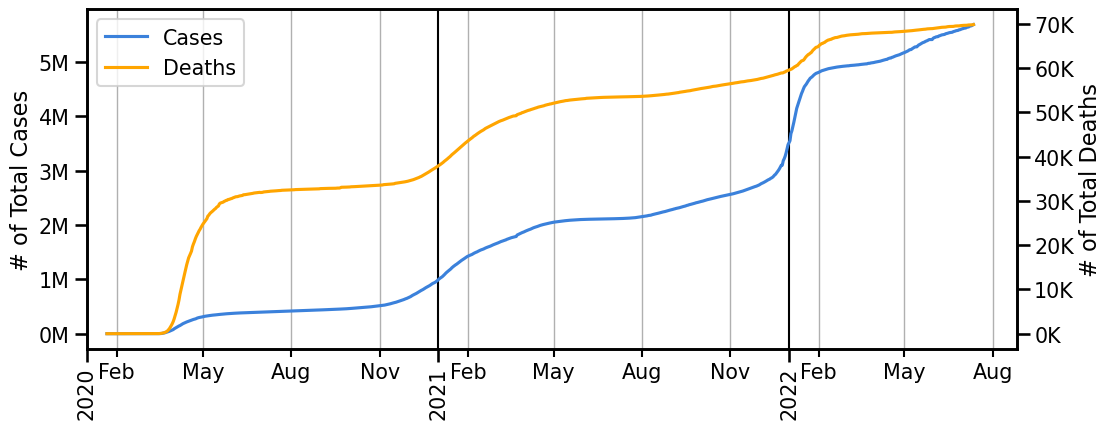

In [27]:
final_fig, (ax1, ax2) = plot_compare_cols(state_ts)
ax1.set_xlim(left=pd.to_datetime('01/2020'))
## Set y-axes major formatters
ax1.yaxis.set_major_formatter(fmt_mill)
ax2.yaxis.set_major_formatter(fmt_thous)
# Customize minor ticks
ax1.xaxis.set_minor_locator(loc_3months)
ax1.xaxis.set_minor_formatter(fmt_months)
# Customize major ticks
ax1.xaxis.set_major_locator(loc_year)
ax1.xaxis.set_major_formatter(fmt_year)
# Make major/minor gridlines visually different
ax1.grid(which='minor', axis='x', lw=1)
ax1.grid(which='major', axis='x', color='k')
final_fig.autofmt_xdate(which='major', rotation=90, ha='center')